In [1]:
import sys
import numpy as np
import math
import ceo
from IPython.display import display, clear_output
%pylab inline
%run ../GMT_DOS_SAO.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
nPx = N_PX_LENSLET*N_LENSLET+1
print "pupil sampling:      %d pixel"%nPx
detectorRes = 2.0*N_PX_LENSLET*N_LENSLET/2.0
print "detector resolution: %d pixel"%detectorRes
zenith_angle  = np.ones((1,N_GS))*zenith_distance_arcmin*ceo.constants.ARCMIN2RAD # in radians
azimuth_angle = np.arange(N_GS)*360.0/N_GS # in degrees
gs    = ceo.Source(AGWS_photometric_band,
                   zenith=zenith_angle,azimuth=azimuth_angle*math.pi/180,
                   rays_box_size=entrance_pupil_size_meter,
                   rays_box_sampling=nPx,rays_origin=[0.0,0.0,25],
                  magnitude=15,fwhm=10.6)
wfs = ceo.ShackHartmann(N_LENSLET, N_PX_LENSLET, lenslet_pitch_meter, 
                        N_PX_IMAGE=40,BIN_IMAGE=4,N_GS=N_GS)
gmt = ceo.GMT_MX(entrance_pupil_size_meter,nPx,
                 M1_radial_order=M1_zernike_radial_order,
                 M2_radial_order=M1_zernike_radial_order)
wfs.camera.photoelectron_gain = optics_throughtput

pupil sampling:      469 pixel
detector resolution: 468 pixel


In [3]:
from scipy.optimize import brentq
def ee80(_psf_,_px_scale_):
    n,m = _psf_.shape
    u = np.linspace(-1,1,n)*(n/2)
    v = np.linspace(-1,1,m)*(m/2)
    x,y = np.meshgrid(u,v)
    def ee80_fun(ee_Delta):
        _ee_Delta_ = (ee_Delta-1)/2
        gate = np.logical_and(np.abs(x)<=_ee_Delta_,np.abs(y)<=_ee_Delta_)
        return np.sum(psf*gate)/(src.nPhoton*368) - 0.8
    try:
        q = brentq(ee80_fun,1,81)*_px_scale_*ceo.constants.RAD2MAS
    except ValueError:
        q = np.float('inf')
    return q

pixel size: 1.27mas


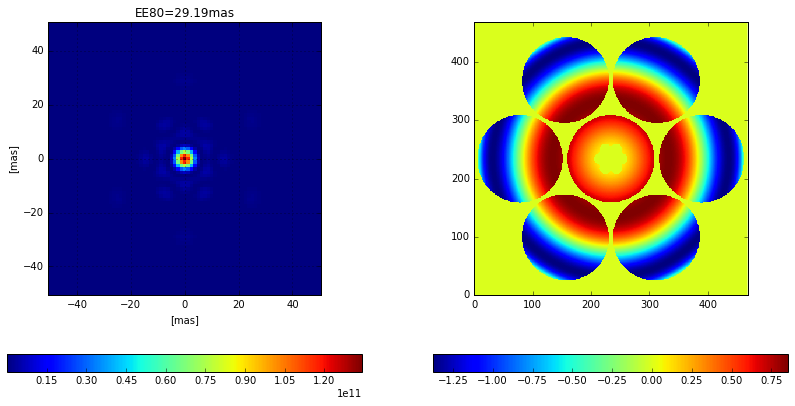

In [4]:
src = ceo.Source(S_photometric_band,
                 rays_box_size=entrance_pupil_size_meter,
                 rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
gmt.reset()
gmt.propagate(src)
imgr = ceo.Imaging(1, nPx-1,DFT_osf=2*nyquist_oversampling_factor,
                   N_PX_IMAGE=detector_resolution,N_SOURCE=src.N_SRC)
imgr.propagate(src)
fig, (ax1,ax2) = subplots(nrows=1,ncols=2)
fig.set_size_inches((14,7))
psf = imgr.frame.host()
px_scale = src.wavelength/(entrance_pupil_size_meter*4)
h1 = ax1.imshow(psf,interpolation='none',origin='lower',extent=[x*px_scale*ceo.constants.RAD2MAS for x in [-40,40,-40,40]])
ax1.grid()
ax1.set_xlabel('[mas]')
ax1.set_ylabel('[mas]')
ee80_0 = ee80(psf,px_scale)
ax1.set_title("EE80=%.2fmas"%ee80_0)
colorbar(h1,ax=ax1,orientation='horizontal')
h2 = ax2.imshow(src.wavefront.phase.host(shape=(nPx*src.N_SRC,nPx),units='nm').T,interpolation='none',origin='lower')
colorbar(h2,ax=ax2,orientation='horizontal')
print "pixel size: %.2fmas"%(px_scale*ceo.constants.RAD2MAS)

In [5]:
4*ceo.constants.ARCMIN2RAD*1e6

1163.5528346628864

# Calibrations
## Wavefront sensors

[ 4600.67529297  4601.47949219  4601.47998047]


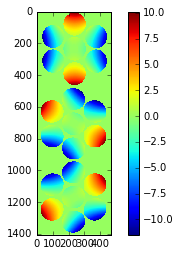

In [6]:
gmt.reset()
gs.reset()
gmt.propagate(gs)
ps0 = gs.phase.host(units='micron')
imshow(ps0,interpolation='None')
colorbar()
print gs.wavefront.rms()*1e9
wfs.calibrate(gs,0.8)

In [7]:
print wfs.frame.shape
print "Pixel size: %.3farcsec"%(wfs.pixel_scale_arcsec)
print "Field of view: %.3farcsec"%(wfs.pixel_scale_arcsec*wfs.N_PX_IMAGE/4)

(780, 260)
Pixel size: 0.264arcsec
Field of view: 2.640arcsec


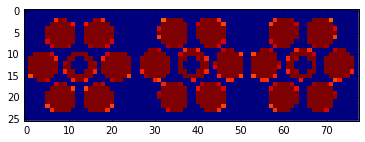

In [8]:
imshow(wfs.flux.host().T,interpolation='none')

## M2 tip-tilt

___ M2 ___
Segment #:1 2 3 4 5 6 7 
------------
M2 tip-tilt interaction matrix condition #:   1.14


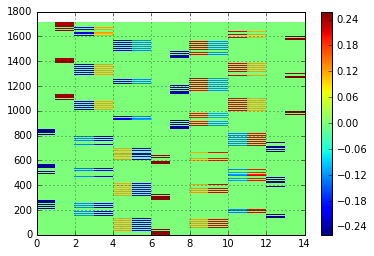

In [9]:
D2tt = gmt.calibrate(wfs,gs,mirror="M2",mode="segment tip-tilt",stroke=200*ceo.constants.MAS2RAD)
fig, ax = subplots()
h = ax.pcolor(D2tt)
colorbar(h)
grid()
print "M2 tip-tilt interaction matrix condition #: %6.2f"%np.linalg.cond(D2tt)
M2tt = np.linalg.pinv(D2tt)

## M1 tip-tilt

___ M1 ___
Segment #:1 2 3 4 5 6 7 
------------
M1 tip-tilt interaction matrix condition #:   1.14


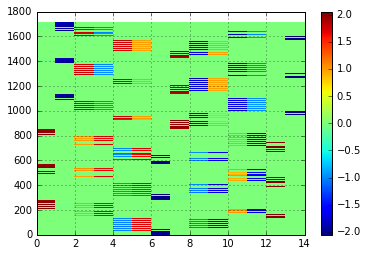

In [10]:
D1tt = gmt.calibrate(wfs,gs,mirror="M1",mode="segment tip-tilt",stroke=25*ceo.constants.MAS2RAD)
fig, ax = subplots()
h = ax.pcolor(D1tt)
colorbar(h)
grid()
print "M1 tip-tilt interaction matrix condition #: %6.2f"%np.linalg.cond(D1tt)
M1tt = np.linalg.pinv(D1tt)

## Combining M1 and M2 tip-tilt interaction matrix

M1/M2 tip-tilt interaction matrix condition #: 5786.24


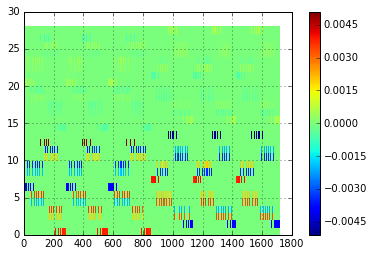

In [11]:
Dtt = np.concatenate((D1tt,D2tt),axis=1)
print "M1/M2 tip-tilt interaction matrix condition #: %6.2f"%np.linalg.cond(Dtt)
Mtt = np.linalg.pinv(Dtt,1e-3)
fig, ax = subplots()
h = ax.pcolor(Mtt)
colorbar(h)
grid()

## M1 Zernike

___ M1 ___
Segment #0: 4 5 6 7 8 9 10 
Segment #1: 4 5 6 7 8 9 10 
Segment #2: 4 5 6 7 8 9 10 
Segment #3: 4 5 6 7 8 9 10 
Segment #4: 4 5 6 7 8 9 10 
Segment #5: 4 5 6 7 8 9 10 
Segment #6: 4 5 6 7 8 9 10 
------------
M1 Zernike interaction matrix condition #:   1.67


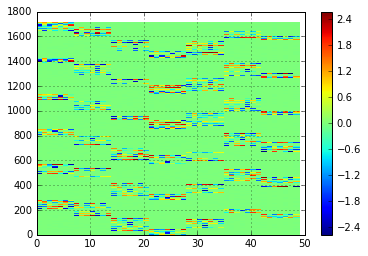

In [12]:
gmt.reset()
gs.reset()
D1z = gmt.calibrate(wfs,gs,mirror="M1",mode="zernike",stroke=1e-6)
fig, ax = subplots()
h = ax.pcolor(D1z)
colorbar(h)
grid()
print "M1 Zernike interaction matrix condition #: %6.2f"%np.linalg.cond(D1z)
M1z = np.linalg.pinv(D1z)

## M2 Zernike

___ M2 ___
Segment #0: 4 5 6 7 8 9 10 
Segment #1: 4 5 6 7 8 9 10 
Segment #2: 4 5 6 7 8 9 10 
Segment #3: 4 5 6 7 8 9 10 
Segment #4: 4 5 6 7 8 9 10 
Segment #5: 4 5 6 7 8 9 10 
Segment #6: 4 5 6 7 8 9 10 
------------
M2 Zernike interaction matrix condition #:   1.64


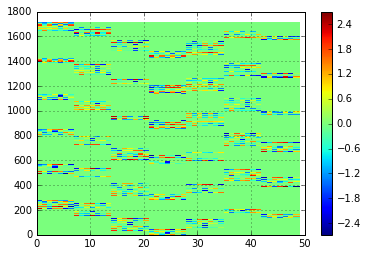

In [13]:
gmt.reset()
gs.reset()
D2z = gmt.calibrate(wfs,gs,mirror="M2",mode="zernike",stroke=1e-6)
fig, ax = subplots()
h = ax.pcolor(D2z)
colorbar(h)
grid()
print "M2 Zernike interaction matrix condition #: %6.2f"%np.linalg.cond(D2z)
M2z = np.linalg.pinv(D2z)

## Combining M1 and M2 Zernike interaction matrix

M1/M2 Zernike interaction matrix condition #:  19.37


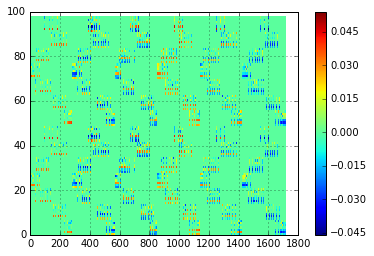

In [14]:
Dz = np.concatenate((D1z,D2z),axis=1)
print "M1/M2 Zernike interaction matrix condition #: %6.2f"%np.linalg.cond(Dz)
Mz = np.linalg.pinv(Dz)#,1e-3)
fig, ax = subplots()
h = ax.pcolor(Mz)
colorbar(h)
grid()

## Combining M1 and M2 tip-tilt and Zernike interaction matrix

M1/M2 Zernike interaction matrix condition #: 9540.55


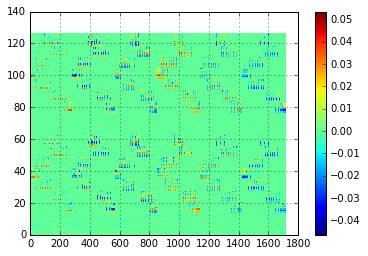

In [15]:
D = np.concatenate((D1tt,D1z,D2tt,D2z),axis=1)
print "M1/M2 Zernike interaction matrix condition #: %6.2f"%np.linalg.cond(D)
M = np.linalg.pinv(D,1e-3)
fig, ax = subplots()
h = ax.pcolor(M)
colorbar(h)
grid()

## Perturbations

In [16]:
gmt.reset()

### M1 tip-tilt

In [17]:
gmt.M1.motion_CS.euler_angles[:,:2] = 0.1*(np.random.rand(7,2)*2-1)*ceo.constants.ARCSEC2RAD
gmt.M1.motion_CS.update()

### M1 Zernike

In [18]:
print M1z.shape
print gmt.M1.zernike.a[:,3:].shape
control_M1_nMode = gmt.M1.zernike.n_mode - 3
gmt.M1.zernike.a[:,3:] = (np.random.rand(7,control_M1_nMode)*2-1)*0.1e-6
gmt.M1.zernike.update()

(49, 1716)
(7, 7)


### M2 tip-tilt

In [19]:
gmt.M2.motion_CS.euler_angles[:,:2] = 0.25*(np.random.rand(7,2)*2-1)*ceo.constants.ARCSEC2RAD
gmt.M2.motion_CS.update()

### M2 Zernike

In [20]:
control_M2_nMode = gmt.M2.zernike.n_mode - 3
gmt.M2.zernike.a[:,3:] = (np.random.rand(7,control_M2_nMode)*2-1)*1e-6
gmt.M2.zernike.update()

### On-axis WFE

In [21]:
src.reset()
gmt.propagate(src)
imgr.reset()
imgr.propagate(src)
print src.wavefront.rms(-9)

[ 3167.29892802]


## Closing the loop

Initial WFE rms: 3167.30nm


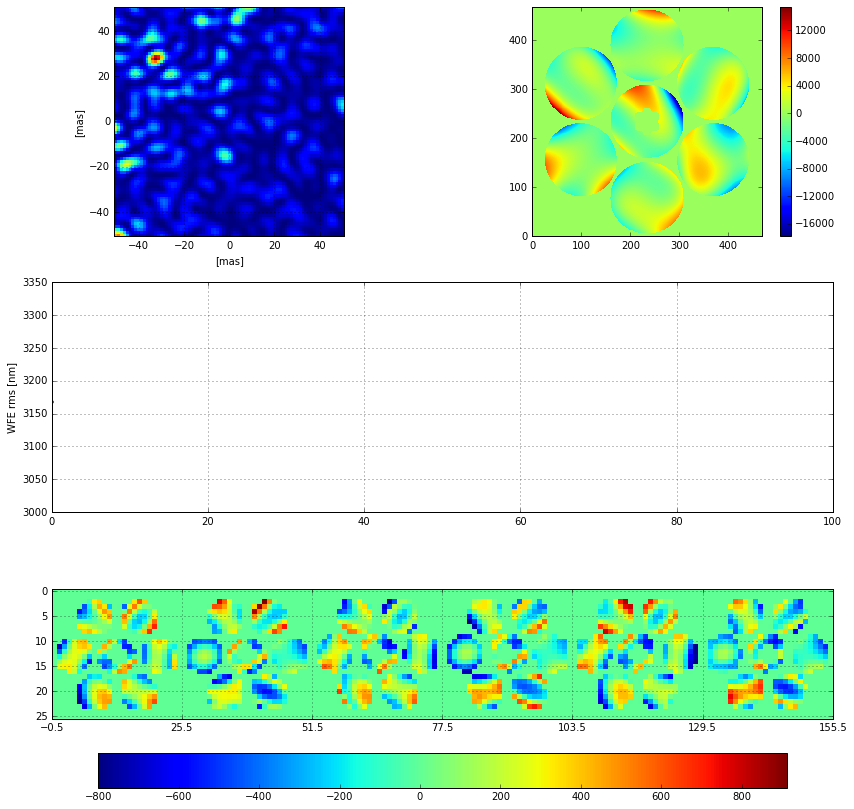

In [22]:
tid = ceo.StopWatch()
nStep = 100

gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)

src.reset()
gmt.propagate(src)
imgr.reset()
imgr.propagate(src)

fig = figure()
fig.set_size_inches((14,14))
ax1 = plt.subplot2grid((3,2),(0,0))
ax2 = plt.subplot2grid((3,2),(0,1))
ax3  = plt.subplot2grid((3,2),(1,0), colspan=2)
ax4 = plt.subplot2grid((3,2),(2,0), colspan=2)

psf = imgr.frame.host()

h1 = ax1.imshow(psf,interpolation='none',origin='lower',extent=[x*px_scale*ceo.constants.RAD2MAS for x in [-40,40,-40,40]])
ax1.grid()
ax1.set_xlabel('[mas]')
ax1.set_ylabel('[mas]')
#ax1.set_title("EE80=%.2fmas"%ee80(psf,px_scale))

h2 = ax2.imshow(src.phase.host(units='nm'),interpolation='none',origin='lower')
colorbar(h2,ax=ax2)

wfe_rms = np.zeros(nStep+1)
wfe_rms[0] = src.wavefront.rms(-9)
h3, = ax3.plot(wfe_rms[:1],'.-')
ax3.grid()
ax3.set_ylabel("WFE rms [nm]")
ax3.set_xlim((0,nStep))
ax3.set_autoscaley_on(True)
print "Initial WFE rms: %6.2fnm"%wfe_rms[0]

c = wfs.c.host(shape=(2*N_GS*N_LENSLET,N_LENSLET),units='mas').T
h4 = ax4.imshow(c,interpolation='none')
colorbar(h4,ax=ax4,orientation='horizontal')
h4.set_label("[mas]")
ax4.set_xticks(np.arange(0,N_LENSLET*(2*gs.N_SRC+1),N_LENSLET)-0.5)
ax4.grid()

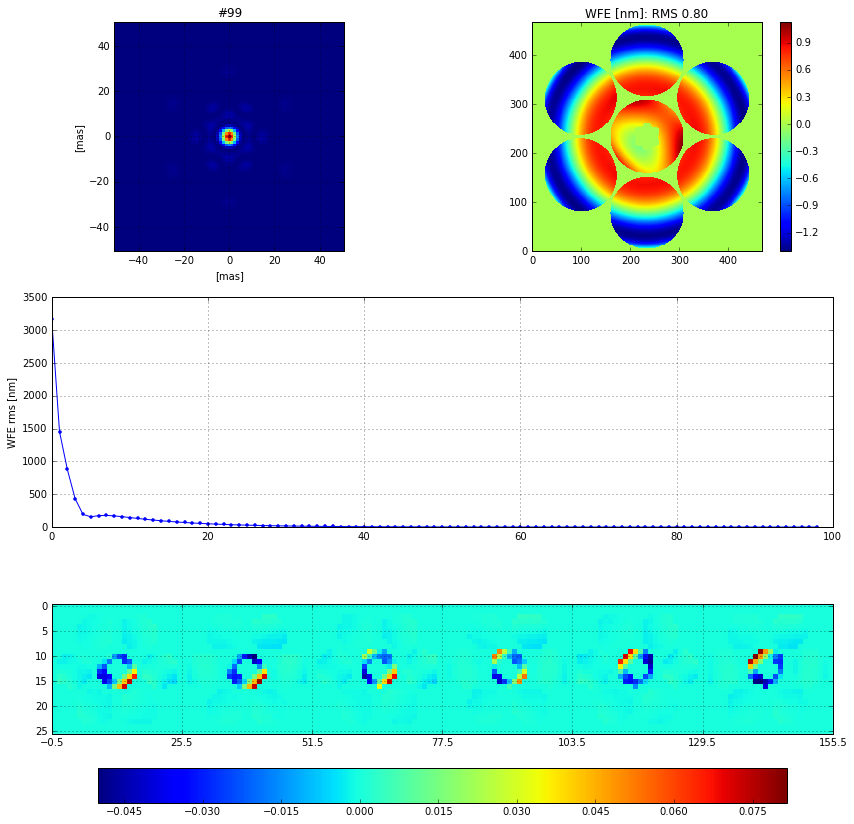

Elapsed time: 104.93s


In [23]:
idx = -1
M2_c = np.zeros((14,1))
M1_c = np.zeros((14,1))
control_M1_seg_nMode = gmt.M1.zernike.n_mode - 3
control_M1_nMode = 7*control_M1_seg_nMode
M1_za = np.zeros((control_M1_nMode,1))
control_M2_seg_nMode = gmt.M2.zernike.n_mode - 3
control_M2_nMode = 7*control_M2_seg_nMode
M2_za = np.zeros((control_M2_nMode,1))

M1_gain = 0.1
M2_gain = 0.5

tid.tic()
for kStep in range(nStep):
    
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
    
    src.reset()
    gmt.propagate(src)
    imgr.reset()
    imgr.propagate(src)
    psf = imgr.frame.host()
    
    s = wfs.valid_slopes.host(shape=(wfs.n_valid_slopes,1))
    M12_c = np.dot(M,s)
    #M12_za= np.dot(Mz,s)
    
    M1_c -= M1_gain*M12_c[:14]
    gmt.M1.motion_CS.euler_angles[:,:2] = M1_c.reshape(7,2)
    gmt.M1.motion_CS.update()
    
    M1_za -= M1_gain*M12_c[14:14+control_M1_nMode]
    gmt.M1.zernike.a[:,3:] = M1_za.reshape(7,control_M1_seg_nMode) 
    gmt.M1.zernike.update()
    
    M2_c -= M2_gain*M12_c[14+control_M1_nMode:28+control_M1_nMode]
    gmt.M2.motion_CS.euler_angles[:,:2] = M2_c.reshape(7,2)
    gmt.M2.motion_CS.update()
    
    M2_za -= M2_gain*M12_c[28+control_M1_nMode:]
    gmt.M2.zernike.a[:,3:] = M2_za.reshape(7,control_M2_seg_nMode) 
    gmt.M2.zernike.update()
    
    wfe = src.phase.host(units='nm')
    idx += 1
    idx = idx%(nStep+1)
    wfe_rms[idx] = 1e9*src.wavefront.rms()

    ax3.relim()
    ax3.autoscale_view(scaley=True)
    
    if kStep<nStep:
        h3.set_data(arange(idx),wfe_rms[:idx])
    else:
        h3.set_data(arange(nStep+1),np.roll(wfe_rms,-idx-1))
    
    h1.set_data(psf)
    h1.set_clim((psf.min(),psf.max()))
    ax1.set_title("#%d"%(kStep))

    h2.set_data(wfe)
    h2.set_clim((wfe.min(),wfe.max()))
    ax2.set_title( "WFE [nm]: RMS %4.2f"%wfe_rms[idx])
        
    c = wfs.c.host(shape=(2*N_GS*N_LENSLET,N_LENSLET),units='mas').T
    h4.set_data(c)
    h4.set_clim((c.min(),c.max()))

#    time.sleep(3)
    
    
    clear_output(wait=True)
    display(fig)
plt.close()    
tid.toc()
print "Elapsed time: %.2fs"%(1e-3*tid.elapsedTime)

In [24]:
print gmt.M1.motion_CS.euler_angles[:]*ceo.constants.RAD2MAS

[[  1.06436960e-04  -4.70586394e-04   0.00000000e+00]
 [  1.86875258e-05  -9.72233369e-06   0.00000000e+00]
 [ -3.47189480e-05  -1.36916179e-04   0.00000000e+00]
 [  1.67395841e-04   3.87857641e-04   0.00000000e+00]
 [  1.20878743e-04   4.34230343e-05   0.00000000e+00]
 [  1.35587336e-04   6.99886693e-05   0.00000000e+00]
 [ -5.26597153e-03   5.16159590e-03   0.00000000e+00]]


In [25]:
print gmt.M2.motion_CS.euler_angles[:]*ceo.constants.RAD2MAS

[[ -7.31673439e-05   3.02987957e-04   0.00000000e+00]
 [ -1.50654141e-05  -6.87311027e-06   0.00000000e+00]
 [  2.11585530e-05   9.87754695e-05   0.00000000e+00]
 [ -1.11545665e-04  -2.51197789e-04   0.00000000e+00]
 [ -7.97227916e-05  -1.39541048e-05   0.00000000e+00]
 [ -1.01923584e-04  -7.10204930e-05   0.00000000e+00]
 [  3.31632338e-03  -3.24856871e-03   0.00000000e+00]]


In [26]:
print gmt.M1.zernike.a[:]*1e9

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.25082087e-03
   -2.18983706e-03   4.28925237e-05  -7.49527897e-04  -3.80164287e-03
   -4.14267113e-04   5.84426692e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -2.21706076e-05
   -2.84404077e-03   3.09702958e-03  -1.95568121e-04  -1.48308510e-04
   -4.33800539e-04  -5.98019536e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -5.34663162e-05
    2.04903278e-03   3.37662011e-03   1.70168651e-04  -2.54901490e-04
   -3.58920242e-04   1.01586451e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -9.95073665e-04
    2.26901943e-03   5.32588992e-04   5.32892336e-04  -3.19285439e-03
    5.07224322e-04   4.26153868e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -3.73763153e-04
    1.47515900e-03  -3.95664057e-03   1.29088665e-04   1.23554136e-04
    2.28124396e-04   7.26493917e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.65152289e-03
   -1.78207716e-03  -8.81291495e-03  -2.86962

In [27]:
print gmt.M2.zernike.a[:]*1e9

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.87177499e-04
   -1.55230297e-04  -8.68737343e-05   3.64652015e-04   1.62765251e-03
   -1.54441810e-04  -4.93673989e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -5.44928666e-05
    1.08882726e-04   1.47241921e-04   8.49732480e-05   1.48920140e-04
   -4.03433192e-05  -6.34866067e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.08488171e-04
   -3.58913314e-05   1.79273892e-04  -5.80734405e-05   8.97372393e-05
    1.47732137e-05  -1.83295911e-05]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -2.67437866e-04
    7.78729101e-05  -1.41196500e-04  -2.38062957e-04   1.60261729e-03
    7.75548132e-05  -4.94601743e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -9.96245984e-05
   -1.16969018e-04  -3.55405566e-04  -1.04013800e-04  -7.38684199e-05
   -2.33014750e-05   1.82730650e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -2.16724506e-04
    1.95872113e-04  -2.19206768e-04   1.03469

In [28]:
control_M1_nMode

49